In [166]:
from Bio import SeqIO
for record in SeqIO.parse("pdb/pdb7b3y.ent", "pdb-seqres"):
    print("Record id %s, chain %s" % (record.id, record.annotations["chain"]))
    print(record)
len(record.seq)

Record id 7B3Y:B, chain B
ID: 7B3Y:B
Name: 7B3Y:B
Description: UNP:A0A0H3BX48 A0A0H3BX48_STRPZ
Database cross-references: UNP:A0A0H3BX48, UNP:A0A0H3BX48_STRPZ, UNP:Q9WXS1, UNP:Q9WXS1_THEMA
Number of features: 0
/chain=B
/molecule_type=protein
Seq('MGSSVTTLSGLSGEQGPSGDMTTEEDSATHIKFSKRDEDGRELAGATMELRDSS...PEA')


341

In [155]:
amino_acid_codes = {
    "ALA": "A",
    "ARG": "R",
    "ASN": "N",
    "ASP": "D",
    "CYS": "C",
    "GLN": "Q",
    "GLU": "E",
    "GLY": "G",
    "HIS": "H",
    "ILE": "I",
    "LEU": "L",
    "LYS": "K",
    "MET": "M",
    "PHE": "F",
    "PRO": "P",
    "SER": "S",
    "THR": "T",
    "TRP": "W",
    "TYR": "Y",
    "VAL": "V"
}

In [194]:
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.Chain import Chain
from Bio.PDB.internal_coords import *
from Bio.PDB.PICIO import write_PIC, read_PIC, read_PIC_seq
from Bio.PDB.ic_rebuild import write_PDB, IC_duplicate, structure_rebuild_test
from Bio.PDB.SCADIO import write_SCAD
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.PDB.PDBIO import PDBIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from Bio.PDB import PDBList

window_size = 7

protein_ids = ['2m7d', '7B3Y', '8C9N', '7LYJ', '6YUN', '7QCT', '6XRZ', '8UYS', '8FU7']
protein_ids = [protein_ids[1]]
protein_id_pdb = protein_ids[0]
proteins = []

# phi_psi = pd.DataFrame(columns=['seq','phi', 'psi', 'chain', 'pos_in_chain', 'protein_id'])
phi_psi_by_residue = pd.DataFrame(columns=['res','phi', 'psi', 'seq', 'idx_in_seq', 'chain', 'pos_in_chain', 'protein_id'])

for protein_id in protein_ids:
    parser = PDBParser()

    filename = f"pdb/{protein_id}.pdb"
    filename_ent = f"pdb/pdb{str(protein_id).lower()}.ent"
    if Path(filename).is_file():
        protein = parser.get_structure(protein_id, filename)
    elif Path(filename_ent).is_file():
        protein = parser.get_structure(protein_id, filename_ent)
    else:
        print(f"Downloading {protein_id}")
        pdbl = PDBList()
        filename = pdbl.retrieve_pdb_file(protein_id, pdir='pdb', file_format='pdb', obsolete=False)
        if Path(filename).is_file():
            protein = parser.get_structure(protein_id, filename)

    proteins.append(protein)
    for chain in list(protein.get_chains()):
        chain = protein[0][chain.id]
        if chain.id in phi_psi_by_residue.chain.unique():
            print(f'Duplicate chain found {protein_id} {chain.id}')
            continue

        chain.atom_to_internal_coordinates(verbose=True)
        resultDict = structure_rebuild_test(chain)
        if not resultDict['pass']:
            print(f"Failed {protein_id} {chain.id}")
            continue

        residues = list(chain.get_residues())
        # for i in range(len(residues) - window_size):
        #     # Convert 3 char codes to 1 char codes
        #     key = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[i:i+window_size]])
        #     if not residues[i].internal_coord:
        #         psi,phi = np.nan, np.nan
        #     else:
        #         psi = residues[i].internal_coord.get_angle("psi")
        #         phi = residues[i].internal_coord.get_angle("phi")
        #     phi_psi.loc[len(phi_psi)] = [key, phi, psi, chain.id, residues[i].get_full_id()[3][1], protein.id]
        j = 0
        seq = ''
        for i in range(len(residues)):
            # Convert 3 char codes to 1 char codes
            if j == 0 and i+window_size < len(residues):
                seq = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[i:i+window_size]])
            key = amino_acid_codes.get(residues[i].resname, 'X')
            if not residues[i].internal_coord:
                psi,phi = np.nan, np.nan
            else:
                psi = residues[i].internal_coord.get_angle("psi")
                phi = residues[i].internal_coord.get_angle("phi")
            psi = psi if psi else np.nan
            phi = phi if phi else np.nan
            phi_psi_by_residue.loc[len(phi_psi_by_residue)] = [key, phi, psi, seq, j, chain.id, residues[i].get_full_id()[3][1], protein.id]
            j = (j+1) % window_size

chain B len 202 missing atom(s): [0_K_CB]
chain B len 202 missing atom(s): [1_M_CB]


In [197]:
phi_psi_by_residue.shape

(200, 8)

In [196]:
# phi_psi = phi_psi[~phi_psi.isna().any(axis=1)]
phi_psi_by_residue = phi_psi_by_residue[~phi_psi_by_residue.isna().any(axis=1)]

# PDB Mine API

In [199]:
from Bio import SeqIO
protein_id = protein_ids[0]
for record in SeqIO.parse(f"pdb/pdb{protein_id_pdb.lower()}.ent", "pdb-seqres"):
    print(len(record.seq),record)

341 ID: 7B3Y:B
Name: 7B3Y:B
Description: UNP:A0A0H3BX48 A0A0H3BX48_STRPZ
Database cross-references: UNP:A0A0H3BX48, UNP:A0A0H3BX48_STRPZ, UNP:Q9WXS1, UNP:Q9WXS1_THEMA
Number of features: 0
/chain=B
/molecule_type=protein
Seq('MGSSVTTLSGLSGEQGPSGDMTTEEDSATHIKFSKRDEDGRELAGATMELRDSS...PEA')


In [182]:
from dotenv import load_dotenv
import os
import requests
import time
import pandas as pd
load_dotenv()
PDBMINE_URL = os.getenv("PDBMINE_URL")

response = requests.get(PDBMINE_URL + f'/v1/api/protein/{protein_id_pdb}', verify=False)
assert(response.ok)
protein_data = response.json()

In [200]:

# - residue_chain is some string of amino acids - any length
# - window_size is length sliding window that will create windows of amino
#   acids to search for. Eg. AKYVCKICGYIYDEDAGDPDNGVSPG with window size 7 
#   will create and search for the following windows:
#    - AKYVCKI, KYVCKIC, YVCKICG, VCKICGY, ...
# - code_length is the length of the amino acid codes used in the residue_chain (1 or 3)
residue_chain = str(record.seq)
window_size = 7
code_length = 1
response = requests.post(
    PDBMINE_URL + '/v1/api/query',
    json={
        "residueChain": residue_chain,
        "codeLength": code_length,
        "windowSize": window_size
    }
)
assert(response.ok)
print(response.json())
query_id = response.json().get('queryID')
assert(query_id)

{'status': 'Running', 'queryID': 'ee55ff23-e9c3-11ee-b41b-0242ac110002'}


In [206]:
response = requests.get(PDBMINE_URL + f'/v1/api/query/{query_id}')
if response.ok:
    matches = response.json()['frames']
else:
    print('waiting')

- matches contains keys for each window, eg. 000_AKYVCKI, 001_KYVCKIC, 002_YVCKICG, ...
- each window entry contains keys of the protein and chain of matches for that
  window, eg. 2JOF_A, 2LL5_A, 3UC7_A, 3UC7_B
- each match entry contains a list of matches for that protein and chain,
  where each match is a list of the residues in the window and the phi,psi of each residu

For example:
```python
{
  '000_DAYAQWL': {
    '2JOF_A': [
      [
          {'residueName': 'D', 'phi': 360, 'psi': 129.2},
          {'residueName': 'A', 'phi': -65.3, 'psi': -40.7},
          (Y,A,Q,W,L)... 
      ],
      [
          {'residueName': 'D', 'phi': 360, 'psi': 132.8},
          {'residueName': 'A', 'phi': -65.3, 'psi': -40.7},
          (Y,A,Q,W,L)...
      ],
      ...
    ],
    '2LL5_A': [
      ...
    ]
  },
  '001_AYAQWLA': {
    ...
  },
  (rest of windows) ...
}
```

In [ ]:
# # Want to plot the phi, psi angles distrubution for the first residue in each window
# # and compare to phi psi of the first residue in the same window in the protein from PDB
# phi_psi_mined = pd.DataFrame(columns=['seq','phi', 'psi', 'chain', 'protein_id'])
# for k,v in matches.items():
#     seq = k[4:]
#     for protein,seq_matches in matches[k].items():
#         # get phi and psi of first resiude of window for each match
#         protein_id, chain = protein.split('_')
#         for seq_match in seq_matches:
#             phi, psi = seq_match[0]['phi'], seq_match[0]['psi']
#             phi_psi_mined.loc[len(phi_psi_mined)] = [seq, phi, psi, chain, protein_id]

In [207]:
from tqdm import tqdm


phi_psi_mined_by_residue = pd.DataFrame(columns=['res','phi', 'psi', 'seq', 'idx_in_seq', 'chain', 'protein_id'])
for seq_win,v in tqdm(matches.items()):
    seq = seq_win[4:]
    for protein,seq_matches in v.items():
        # get phi and psi of each residue in window for each match
        protein_id, chain = protein.split('_')
        for seq_match in seq_matches:
            for i,match in enumerate(seq_match):
                res, phi, psi = match['residueName'], match['phi'], match['psi']
                phi_psi_mined_by_residue.loc[len(phi_psi_mined_by_residue)] = [res, phi, psi, seq, i, chain, protein_id]

100%|██████████| 335/335 [04:10<00:00,  1.34it/s]


In [208]:
phi_psi_mined_by_residue.to_csv(f'{protein_id_pdb}_phi_psi_mined_by_residue.csv', index=False)
phi_psi_by_residue.to_csv(f'{protein_id_pdb}_phi_psi_by_residue.csv', index=False)

In [212]:
# phi_psi_mined = pd.read_csv('2m7d_phi_psi_mined.csv')
protein_id_pdb = '7B3Y'
phi_psi_mined_by_residue = pd.read_csv(f'{protein_id_pdb}_phi_psi_mined_by_residue.csv')
phi_psi_by_residue = pd.read_csv(f'{protein_id_pdb}_phi_psi_by_residue.csv')

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# protein_id_pdb = phi_psi.protein_id.unique()[0]
# fig, axes = plt.subplots(3,3,figsize=(15,15))

# m=10
# for i,key in enumerate(phi_psi.seq.unique()[m:m+9]):
#     ax = axes.flatten()[i]
#     phi_psi_alpha = phi_psi[phi_psi.seq == key]
#     phi_psi_dist = phi_psi_mined[(phi_psi_mined.seq == key) & (phi_psi_mined.protein_id != protein_id_pdb)]
#     ax.scatter(phi_psi_dist['phi'], phi_psi_dist['psi'], label='Mined Protein Means', color='purple', marker='.')#, c=[{k:v for v,k in enumerate(phi_psi_dist['protein_id'].unique())}[x] for x in phi_psi_dist['protein_id']])
#     sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax)
#     ax.scatter(phi_psi_alpha['phi'], phi_psi_alpha['psi'], label=f'{protein_id_pdb} from PDB', color='red', marker='^')

#     ax.legend()
#     ax.set_title(key)
#     ax.set_xlabel('phi')
#     ax.set_ylabel('psi')
# fig.suptitle(f'Distribution of phi, psi angles for the first residue of different seq windows in {protein_id_pdb}')
# plt.tight_layout()

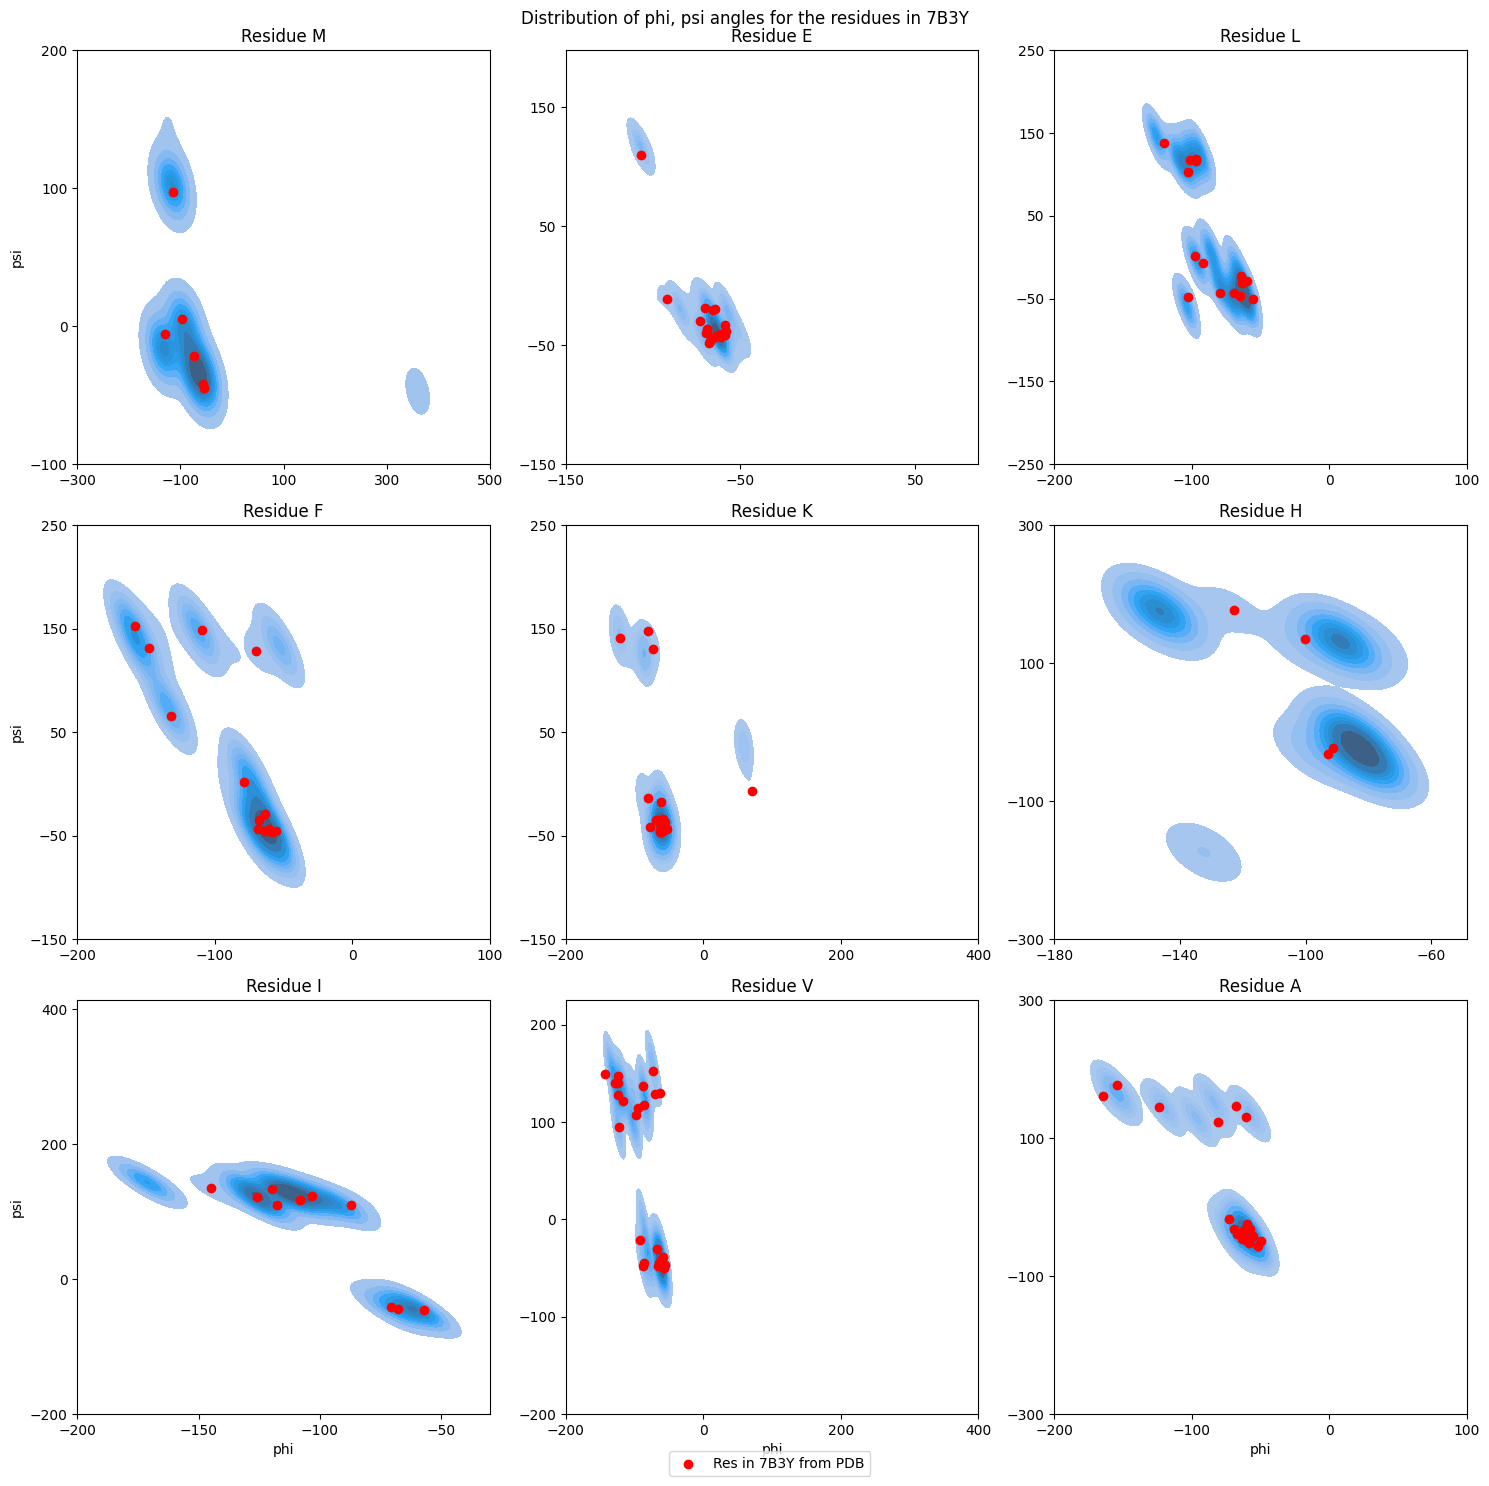

In [218]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,3,figsize=(15,15))

m=0
for i,key in enumerate(phi_psi_by_residue.res.unique()[m:m+9]):
    ax = axes.flatten()[i]
    phi_psi_alpha = phi_psi_by_residue[phi_psi_by_residue.res == key]
    phi_psi_dist = phi_psi_mined_by_residue[(phi_psi_mined_by_residue.res == key) & (phi_psi_mined_by_residue.protein_id != protein_id_pdb)]
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True)
    # ax.scatter(phi_psi_dist['phi'], phi_psi_dist['psi'], label='Res in Matches Found in PDBMine', color='green', marker='.', zorder=5)
    ax.scatter(phi_psi_alpha['phi'], phi_psi_alpha['psi'], label=f'Res in {protein_id_pdb} from PDB', color='red', marker='o', zorder=10)

    ax.set_title(f'Residue {key}')
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_yticks(ax.get_yticks()[::2])
    ax.set_xlabel('phi' if i > 5 else '')
    ax.set_ylabel('psi' if i % 3 == 0 else '')
    if i == 7:
        ax.legend(loc=(0.25,-0.15))
fig.suptitle(f'Distribution of phi, psi angles for the residues in {protein_id_pdb}')
plt.tight_layout()

In [219]:
from sklearn.cluster import KMeans
res = 'H'
phi_psi_dist = phi_psi_mined_by_residue[(phi_psi_mined_by_residue.res == res) & (phi_psi_mined_by_residue.protein_id != protein_id_pdb)][['phi','psi']].to_numpy()
kmeans = KMeans(n_clusters=4)
kmeans.fit(phi_psi_dist)
y_kmeans = kmeans.predict(phi_psi_dist)

/home/mmazeem/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


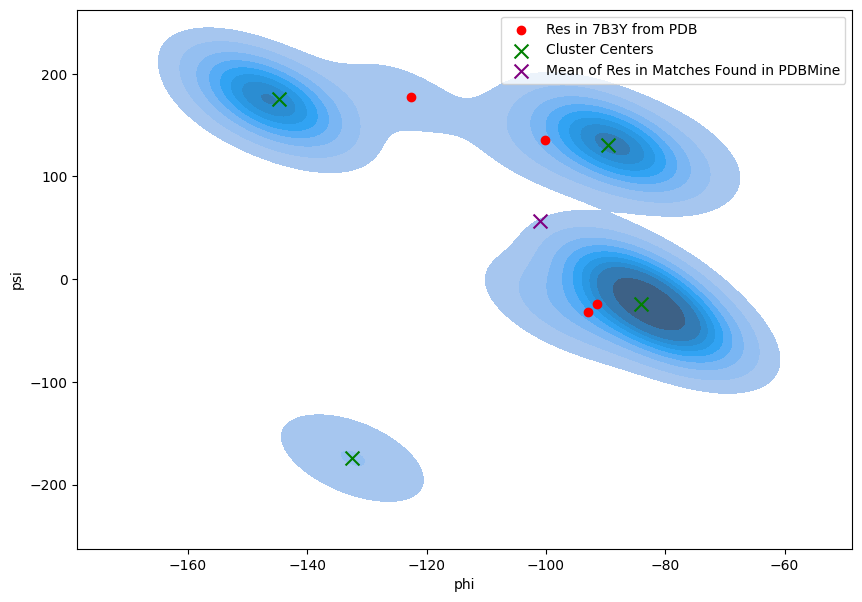

In [220]:
# plot one in detail
fig, ax = plt.subplots(figsize=(10,7))
phi_psi_alpha = phi_psi_by_residue[phi_psi_by_residue.res == res]
phi_psi_dist = phi_psi_mined_by_residue[(phi_psi_mined_by_residue.res == res) & (phi_psi_mined_by_residue.protein_id != protein_id_pdb)]
sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True)
ax.scatter(phi_psi_alpha['phi'], phi_psi_alpha['psi'], label=f'Res in {protein_id_pdb} from PDB', color='red', marker='o', zorder=10)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], label='Cluster Centers', color='green', marker='x', s=100)
ax.scatter(phi_psi_dist['phi'].mean(), phi_psi_dist['psi'].mean(), label='Mean of Res in Matches Found in PDBMine', color='purple', marker='x', s=100)
ax.legend()